### Load and Modify Configuration File

In [1]:
from configs.config_loader import load_config
config = load_config('configs/default.yaml')

version : default
seed : 1
g : 9.81
l : 1
theta0 : 100
omega0 : 0
T : 10
N_col : 1024
N_hidden : 4
N_neurons : 50
activation : tanh
N_epochs : 20000
learning_rate : 0.001
decay_rate : 1.0
freq_log : 100
freq_print : 1000
keys_print : ['loss_P', 'loss_IC']
freq_save : 1000
reg_coeff : 0
reg_decay : 0
reg_epochs : 0


### Initialize Physics-Informed Neural Network

In [2]:
from model.neural_net import PhysicsInformedNN
PINN = PhysicsInformedNN(config, verbose=True)

2024-10-12 16:58:56.563001: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 16:58:56.601671: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 16:58:56.603012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 16:58:57.267111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "PhysicsInformedNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7801 (30.47 KB)
Trainable params: 7801 (30.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
*** PINN build 

### Train Physics-Informed Neural Network

In [3]:
training_log = PINN.train()

Training started...
    0/20000 | loss_P: 1.45e+01 | loss_IC: 3.13e+00
 1000/20000 | loss_P: 2.64e-01 | loss_IC: 2.07e+00
 2000/20000 | loss_P: 3.49e-01 | loss_IC: 2.11e+00
 3000/20000 | loss_P: 3.18e-01 | loss_IC: 2.06e+00
 4000/20000 | loss_P: 3.62e-01 | loss_IC: 2.05e+00
 5000/20000 | loss_P: 3.01e-01 | loss_IC: 2.09e+00
 6000/20000 | loss_P: 3.44e-01 | loss_IC: 2.12e+00
 7000/20000 | loss_P: 3.30e-01 | loss_IC: 2.06e+00
 8000/20000 | loss_P: 4.04e-01 | loss_IC: 2.07e+00
 9000/20000 | loss_P: 4.11e-01 | loss_IC: 2.01e+00
10000/20000 | loss_P: 1.81e-01 | loss_IC: 2.10e+00
11000/20000 | loss_P: 3.28e-01 | loss_IC: 2.08e+00
12000/20000 | loss_P: 3.18e-01 | loss_IC: 2.11e+00
13000/20000 | loss_P: 3.68e-01 | loss_IC: 2.07e+00
14000/20000 | loss_P: 3.61e-01 | loss_IC: 2.06e+00
15000/20000 | loss_P: 3.13e-01 | loss_IC: 2.04e+00
16000/20000 | loss_P: 3.49e-01 | loss_IC: 2.08e+00
17000/20000 | loss_P: 2.36e-01 | loss_IC: 2.15e+00
18000/20000 | loss_P: 3.05e-01 | loss_IC: 2.10e+00
19000/20000

# Plot Section

In [4]:
from model.plots import learning_curves, pendulum_dynamics, loss_over_tcoll

### Learning Curves

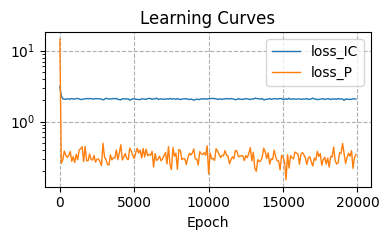

In [5]:
learning_curves(training_log)

### Pendulum Dynamics

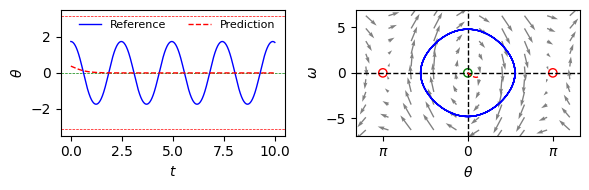

In [6]:
pendulum_dynamics(PINN)

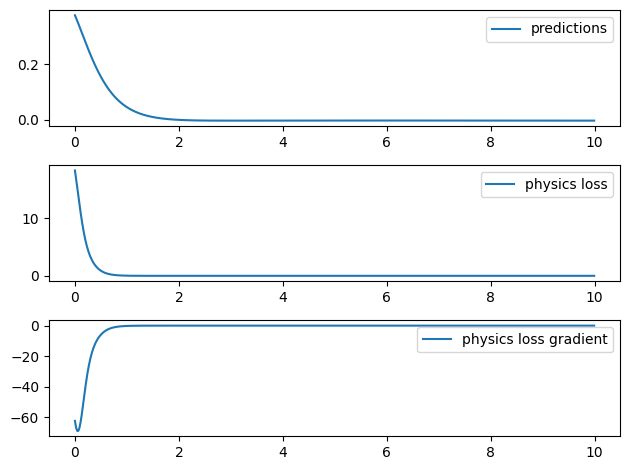

In [7]:
loss_over_tcoll(PINN)

### Training animation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML



def init_fig():

    fig, ax = plt.subplots()

    #############################
    ### Initial plot comes here
    #############################

    plt.tight_layout()
    plt.close(fig)
    return fig, ax


def animate(i, *fargs):
    # get passed arguments
    ax = fargs[0]
    N_times = fargs[1]

    # print status of animation
    print(f'Processed: {i/N_times*100:.0f}%', end='\r')

    # clear axis
    ax.clear()
    #############################
    ### load model weights & make predictions
    #############################
    flag = i * config['freq_save']
    PINN.load_weights(PINN.log_path.joinpath(f'model_weights/weights_{flag}.pkl'))

    ############################
    # Prediciton plot
    ############################

    # stable/unstable fixed points
    line_props = {'ls': '--', 'lw': 0.5}
    ax.axhline(0, c='green', **line_props)
    ax.axhline(np.pi, c='red', **line_props)
    ax.axhline(-np.pi, c='red', **line_props)

    # Reference data and PINN prediction
    t_line, theta_true, omega_true = PINN.data.reference()
    theta_pred = PINN(t_line)
    
    ##############################
    ### Regularization coefficient
    ##############################
    epoch = flag
    coeff = config["reg_coeff"] * (float(config["reg_decay"])**epoch)
    if epoch > (config["reg_epochs"] * config["N_epochs"]):
        coeff = 0
    
    ax.plot([], [], c='black', lw=1, label=f'regularization coeff {coeff}')
           
    #############################
    ### Updated plot comes here
    #############################

    # make plot
    ax.plot(t_line, theta_true, c='blue', lw=1, label='Reference')
    ax.plot(t_line, theta_pred, c='red', lw=1, ls='--', label='Prediction')

    # Axis appearance
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$\theta$')
    ax.legend(frameon=False, loc=1, ncol=2, fontsize=8)
    ax.set_ylim([-3.5, 3.5])
    


    plt.tight_layout()


# should equal the number of saved weights files
N_frames = int(config["N_epochs"] / config["freq_save"])

(fig, ax) = init_fig()
ani = FuncAnimation(fig, animate, frames=N_frames, fargs=(ax, N_frames))
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>